# **Titanic Project**

**About Dataset:** 

The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

**Target**:

To predict what sorts of people were more likely to survive i.e "Survived" in the Dataset.

**Approach**:

In this Project firstly, I will display some feature analysis then ill focus on feature engineering. Last part concerns modeling and predicting the survival on the Titanic using a voting procedure.
In the modeling,I've used feature engineering and ensemble modeling.

# **Importing Libraries**

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from collections import Counter

from sklearn.ensemble import (RandomForestClassifier,
AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
sns.set(style='white', context='notebook', palette='deep')


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **Importing the Dataset**

In [ ]:
# Load data
# Load train and Test set

training_set=pd.read_csv('train.csv')
test_set=pd.read_csv('test.csv')

Idtest=test_set["PassengerId"]

In [ ]:
print(training_set)

     PassengerId  Survived  Pclass  ...     Fare Cabin  Embarked
0              1         0       3  ...   7.2500   NaN         S
1              2         1       1  ...  71.2833   C85         C
2              3         1       3  ...   7.9250   NaN         S
3              4         1       1  ...  53.1000  C123         S
4              5         0       3  ...   8.0500   NaN         S
..           ...       ...     ...  ...      ...   ...       ...
886          887         0       2  ...  13.0000   NaN         S
887          888         1       1  ...  30.0000   B42         S
888          889         0       3  ...  23.4500   NaN         S
889          890         1       1  ...  30.0000  C148         C
890          891         0       3  ...   7.7500   NaN         Q

[891 rows x 12 columns]


In [ ]:
print(test_set)

     PassengerId  Pclass  ... Cabin Embarked
0            892       3  ...   NaN        Q
1            893       3  ...   NaN        S
2            894       2  ...   NaN        Q
3            895       3  ...   NaN        S
4            896       3  ...   NaN        S
..           ...     ...  ...   ...      ...
413         1305       3  ...   NaN        S
414         1306       1  ...  C105        C
415         1307       3  ...   NaN        S
416         1308       3  ...   NaN        S
417         1309       3  ...   NaN        C

[418 rows x 11 columns]


## **Outlier Detection**

In [ ]:
# Outlier detection 

def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(training_set,2,["Age","SibSp","Parch","Fare"])

In [ ]:
#Drop Outliers
training_set.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [ ]:
#Drop Outliers
training_set=training_set.drop(Outliers_to_drop, axis=0).reset_index(drop=True)

## **Joining Train and Test set**

In [ ]:
## Join train and test datasets in order to obtain the same number of features during categorical conversion

dataset=pd.concat(objs=[training_set,test_set],axis=0).reset_index(drop=True)

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1299 entries, 0 to 1298
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1299 non-null   int64  
 1   Survived     881 non-null    float64
 2   Pclass       1299 non-null   int64  
 3   Name         1299 non-null   object 
 4   Sex          1299 non-null   object 
 5   Age          1043 non-null   float64
 6   SibSp        1299 non-null   int64  
 7   Parch        1299 non-null   int64  
 8   Ticket       1299 non-null   object 
 9   Fare         1298 non-null   float64
 10  Cabin        292 non-null    object 
 11  Embarked     1297 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 121.9+ KB


In [ ]:
dataset.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1299.000000,881.000000,1299.000000,1043.000000,1299.000000,1299.000000,1298.000000
mean,657.093149,0.385925,2.294072,29.903806,0.452656,0.372594,32.569058
std,377.743244,0.487090,0.837150,14.427548,0.879416,0.857157,50.694652
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,331.500000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,657.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,984.500000,1.000000,3.000000,39.000000,1.000000,0.000000,30.646850
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


# **checking for null and missing values**

In [ ]:
#Fill empty and NaNs values with NaN
dataset=dataset.fillna(np.nan)

In [ ]:
#Check for Null values
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

In [ ]:
#Infos
training_set.info()
training_set.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [ ]:
training_set.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
training_set.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


# **Feature analysis**

**Numerical Values**

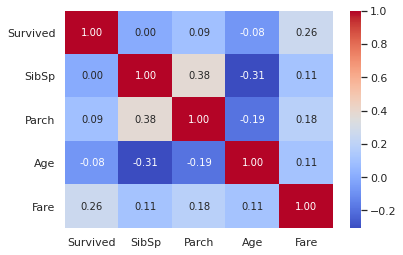

In [ ]:
#Correlation Matrix between numerical values
g=sns.heatmap(training_set[["Survived","SibSp","Parch","Age","Fare"]].corr(),annot=True ,fmt=".2f", cmap="coolwarm")

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3672: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


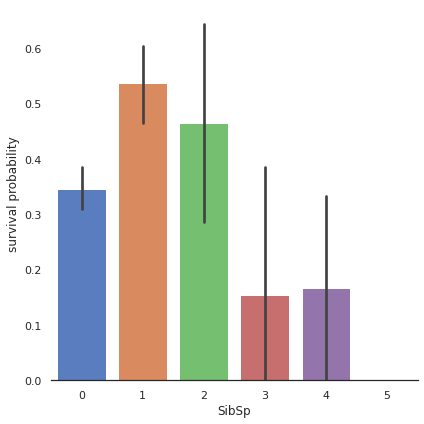

In [ ]:
#sibsp vs survived
g=sns.factorplot(x="SibSp", y="Survived", data=training_set, kind="bar", size=6,palette="muted")
g.despine(left=True)
g=g.set_ylabels("survival probability")

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3672: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


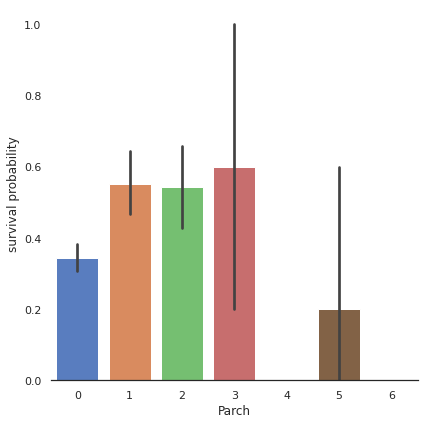

In [ ]:
#Parch vs survived
g=sns.factorplot(x="Parch", y="Survived", data=training_set, kind="bar", size=6,palette="muted")
g.despine(left=True)
g=g.set_ylabels("survival probability")

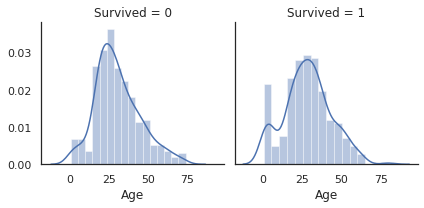

In [ ]:
#Age vs survived
g=sns.FacetGrid(training_set,col='Survived')
g=g.map(sns.distplot,"Age")

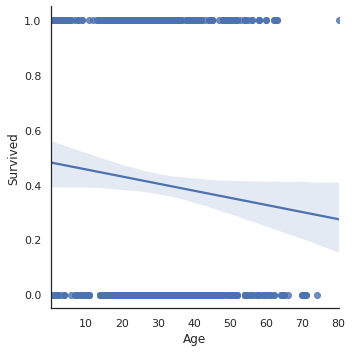

In [ ]:
sns.lmplot("Age","Survived",training_set)

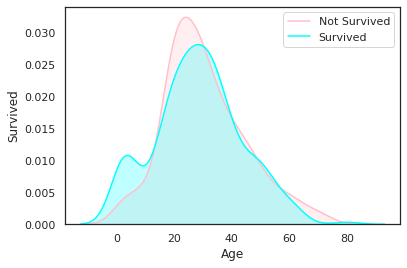

In [ ]:
g=sns.kdeplot(training_set["Age"][(training_set["Survived"]==0) & (training_set["Age"].notnull())],color="Pink", shade=True)
g=sns.kdeplot(training_set["Age"][(training_set["Survived"]==1) & (training_set["Age"].notnull())],color="aqua",shade=True)
g.set_xlabel("Age")
g.set_ylabel("Survived")
g=g.legend(["Not Survived","Survived"])

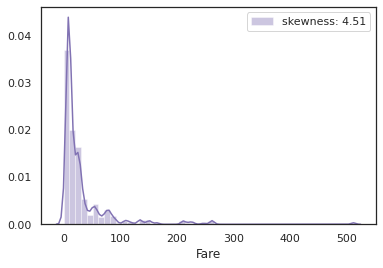

In [ ]:
#Fare
g=sns.distplot(dataset["Fare"],color="m",label="skewness: %.2f"%(dataset["Fare"].skew()))
g=g.legend(loc="best")

In [ ]:
# Apply log to Fare to reduce skewness distribution
dataset["Fare"] = dataset["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

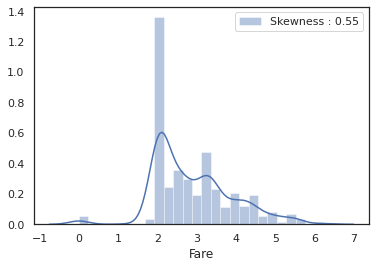

In [ ]:
g = sns.distplot(dataset["Fare"], color="b", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

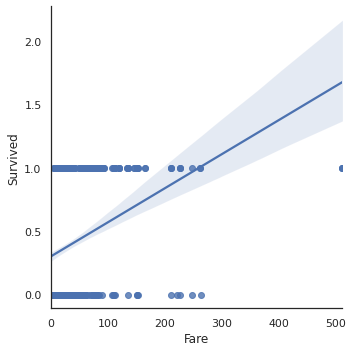

In [ ]:
sns.lmplot("Fare","Survived",training_set)

### **Categorical Values**

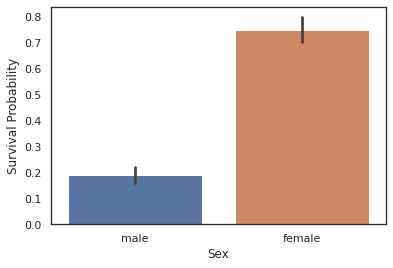

In [ ]:
#Sex vs survived
g=sns.barplot(x="Sex",y="Survived",data=training_set)
g=g.set_ylabel("Survival Probability")

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3672: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


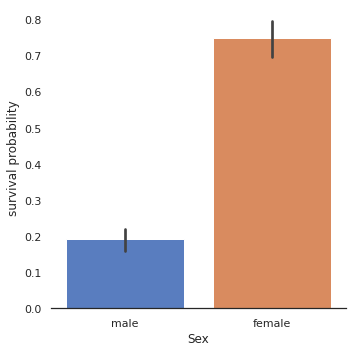

In [ ]:
#Sex vs survived 
g=sns.factorplot(x="Sex", y="Survived",data=training_set, kind="bar", size=5,palette="muted")
g.despine(left=True)
g=g.set_ylabels("survival probability")

In [ ]:
training_set[["Sex","Survived"]].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3672: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


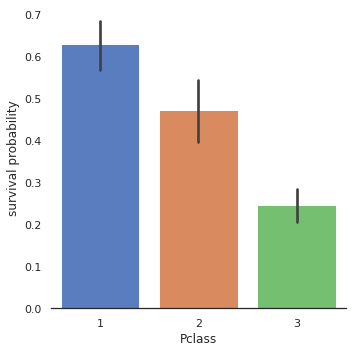

In [ ]:
#Pclass vs survived
g=sns.factorplot(x="Pclass", y="Survived",data=training_set, kind="bar", size=5,palette="muted")
g.despine(left=True)
g=g.set_ylabels("survival probability")

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3672: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


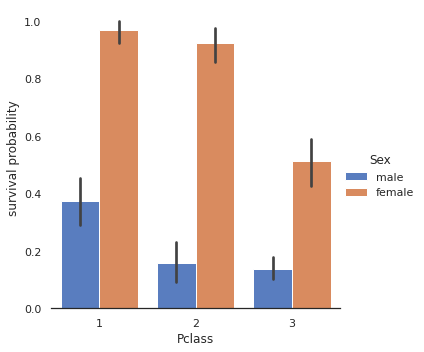

In [ ]:
#Pclass vs Survived vs Sex
g=sns.factorplot(x="Pclass", y="Survived",hue="Sex",data=training_set, kind="bar", size=5,palette="muted")
g.despine(left=True)
g=g.set_ylabels("survival probability")

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3672: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


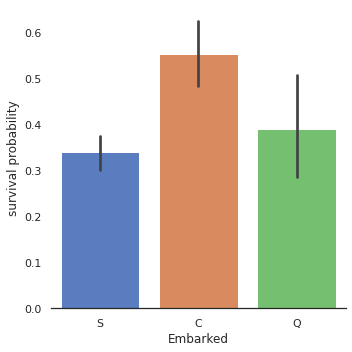

In [ ]:
#Embarked vs Survived
g=sns.factorplot(x="Embarked", y="Survived", data=training_set, kind="bar", size=5,palette="muted")
g.despine(left=True)
g=g.set_ylabels("survival probability")

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3672: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


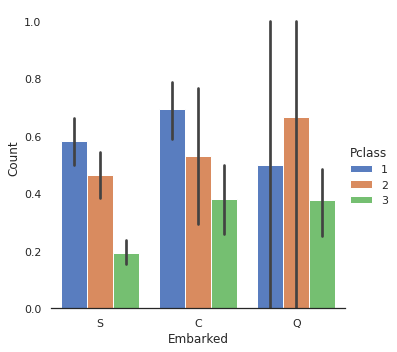

In [ ]:
#Embarked vs Pclass
g=sns.factorplot(x="Embarked", y="Survived",hue="Pclass", data=training_set, kind="bar", size=5,palette="muted")
g.despine(left=True)
g=g.set_ylabels("Count")

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3672: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


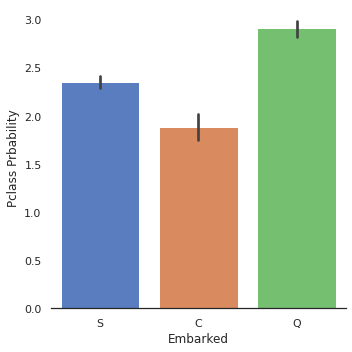

In [ ]:
#Embarked vs Pclass
g=sns.factorplot(x="Embarked", y="Pclass", data=training_set, kind="bar", size=5,palette="muted")
g.despine(left=True)
g=g.set_ylabels("Pclass Prbability")

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3672: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


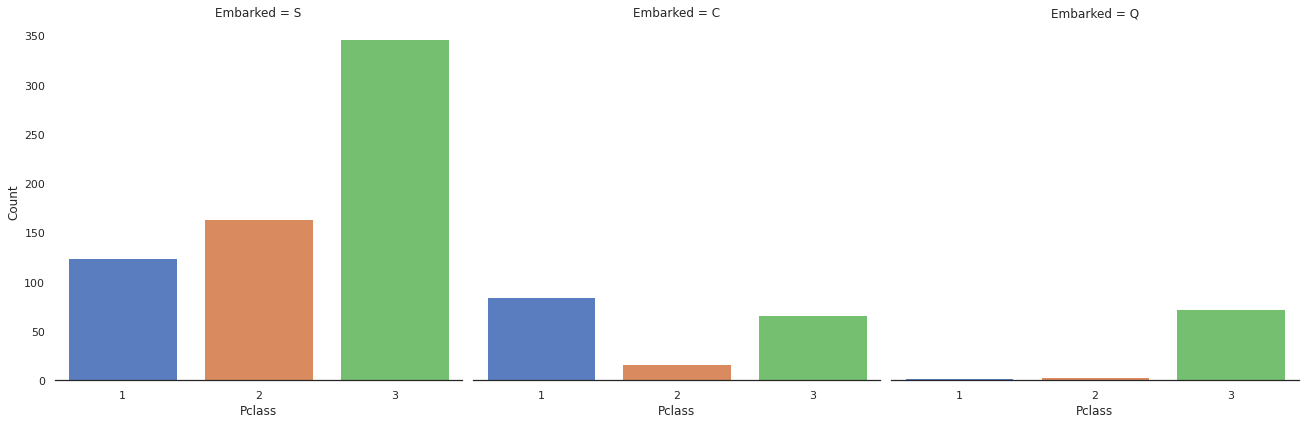

In [ ]:
#Pclass vs Embarked (Count)
g=sns.factorplot("Pclass",col="Embarked", data=training_set, size=6, kind="count", palette="muted")
g.despine(left=True)
g=g.set_ylabels("Count")

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr

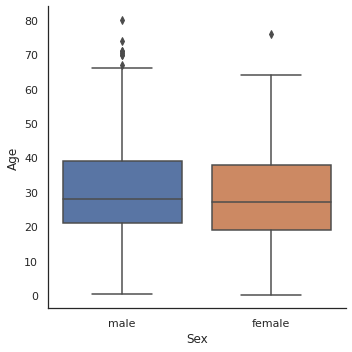

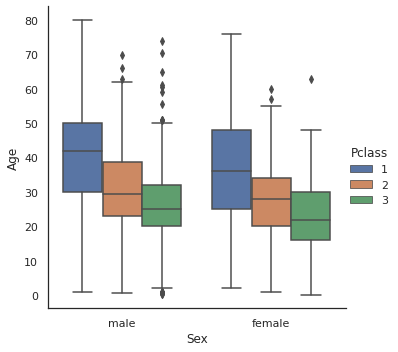

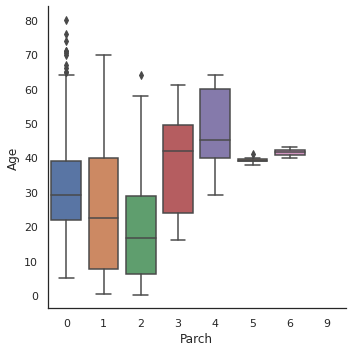

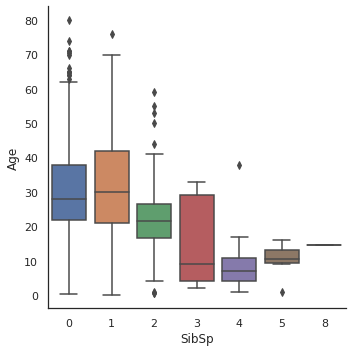

In [ ]:
# Explore Age vs Sex, Parch , Pclass and SibSP
g=sns.factorplot(y="Age", x="Sex", data=dataset, kind="box")
g=sns.factorplot(y="Age", x="Sex", hue="Pclass", data=dataset, kind="box")
g=sns.factorplot(y="Age", x="Parch", data=dataset,kind="box")
g=sns.factorplot(y="Age", x="SibSp", data=dataset,kind="box")

In [ ]:
# convert Sex into categorical value 0 for male and 1 for female
dataset["Sex"]=dataset["Sex"].map({"male":0,"female":1})

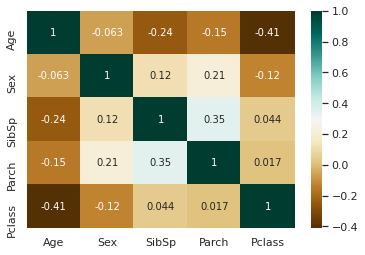

In [ ]:
g=sns.heatmap(dataset[["Age","Sex","SibSp","Parch","Pclass"]].corr(),cmap="BrBG",annot=True)

In [ ]:
# Filling missing value of Age 

## Fill Age with the median age of similar rows according to Pclass, Parch and SibSp
# Index of NaN age rows
index_NaN_age = list(dataset["Age"][dataset["Age"].isnull()].index)

for i in index_NaN_age :
    age_med = dataset["Age"].median()
    age_pred = dataset["Age"][((dataset['SibSp'] == dataset.iloc[i]["SibSp"]) & (dataset['Parch'] == dataset.iloc[i]["Parch"]) & (dataset['Pclass'] == dataset.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred) :
        dataset['Age'].iloc[i] = age_pred
    else :
        dataset['Age'].iloc[i] = age_med

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


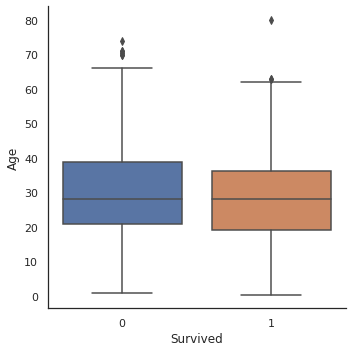

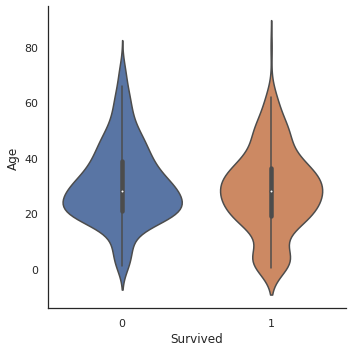

In [ ]:
g = sns.factorplot(x="Survived", y = "Age",data = training_set, kind="box")
g = sns.factorplot(x="Survived", y = "Age",data = training_set, kind="violin")

##**Filling Missing Values**

In [ ]:
#Fare
dataset["Fare"].isnull().sum()
dataset["Fare"]=dataset["Fare"].fillna(dataset["Fare"].median())

In [ ]:
#Embarked
dataset["Embarked"].isnull().sum()
dataset["Embarked"] = dataset["Embarked"].fillna("S")

# **Feature Engineering**

In [ ]:
dataset["Name"].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [ ]:
#Get title from Name
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]
dataset["Title"] = pd.Series(dataset_title)
dataset["Title"].head()


0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

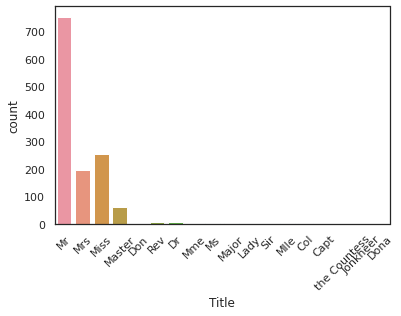

In [ ]:

g=sns.countplot(x="Title",data=dataset)
g=plt.setp(g.get_xticklabels(),rotation=45)

In [ ]:
# Convert to categorical values Title 
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)

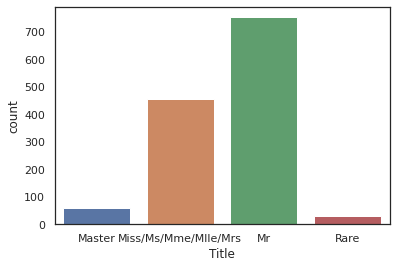

In [ ]:
g=sns.countplot(dataset["Title"])
g=g.set_xticklabels(["Master","Miss/Ms/Mme/Mlle/Mrs","Mr","Rare"])

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


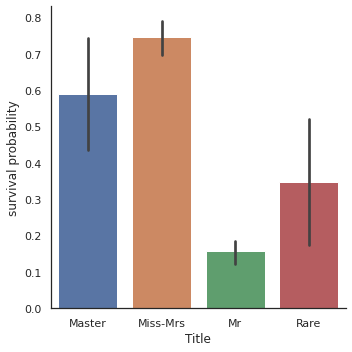

In [ ]:
g=sns.factorplot(x="Title",y="Survived",data=dataset,kind="bar")
g=g.set_xticklabels(["Master","Miss-Mrs","Mr","Rare"])
g=g.set_ylabels("survival probability")

In [ ]:
# Drop Name variable
dataset.drop(labels = ["Name"], axis = 1, inplace = True)

In [ ]:
# Create a family size descriptor from SibSp and Parch
dataset["Fsize"] = dataset["SibSp"] + dataset["Parch"] + 1

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


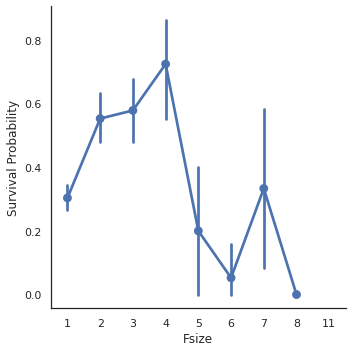

In [ ]:
g=sns.factorplot(x="Fsize",y="Survived",data=dataset)
g=g.set_ylabels("Survival Probability")

In [ ]:
# Create new feature of family size
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if  s == 2  else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s >= 5 else 0)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


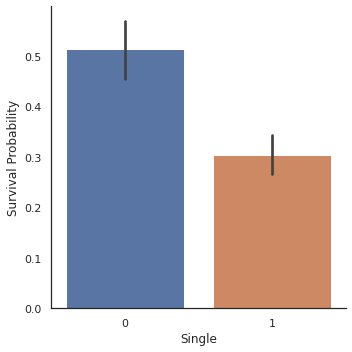

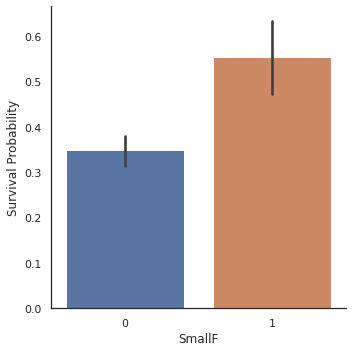

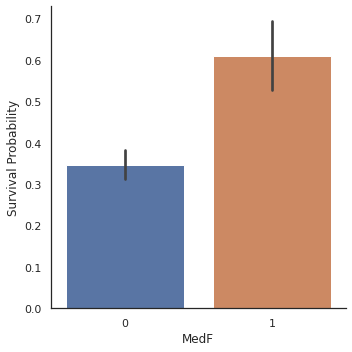

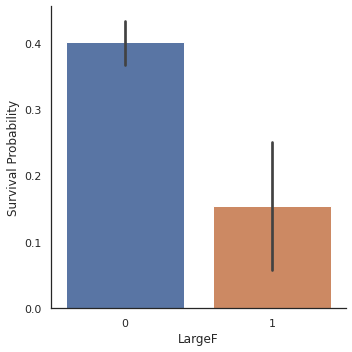

In [ ]:
g=sns.factorplot(x="Single", y="Survived" ,data=dataset,kind="bar")
g=g.set_ylabels("Survival Probability")
g=sns.factorplot(x="SmallF", y="Survived",data=dataset,kind="bar")
g=g.set_ylabels("Survival Probability")
g=sns.factorplot(x="MedF", y="Survived",data=dataset,kind="bar")
g=g.set_ylabels("Survival Probability")
g=sns.factorplot(x="LargeF", y="Survived",data=dataset,kind="bar")
g=g.set_ylabels("Survival Probability")

In [ ]:
# convert to indicator values Title and Embarked 
dataset = pd.get_dummies(dataset, columns = ["Title"])
dataset = pd.get_dummies(dataset, columns = ["Embarked"], prefix="Em")


In [ ]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Fsize,Single,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,2,0,1,0,0,0,0,1,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,2,0,1,0,0,0,1,0,0,1,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,1,1,0,0,0,0,1,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,2,0,1,0,0,0,1,0,0,0,0,1
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,1,1,0,0,0,0,0,1,0,0,0,1


In [ ]:
dataset["Cabin"].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [ ]:
dataset["Cabin"].describe()

count     292
unique    186
top        G6
freq        5
Name: Cabin, dtype: object

In [ ]:
dataset["Cabin"].isnull().sum()

1007

In [ ]:
dataset["Cabin"][dataset["Cabin"].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [ ]:
# Replace the Cabin number by the type of cabin 'X' if not
dataset["Cabin"]=pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin']])

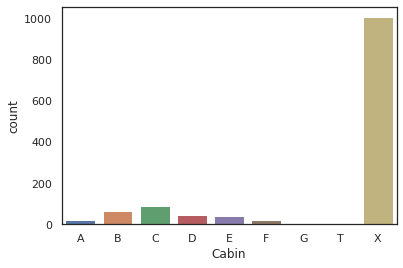

In [ ]:
g=sns.countplot(dataset["Cabin"],order=['A','B','C','D','E','F','G','T','X'])


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


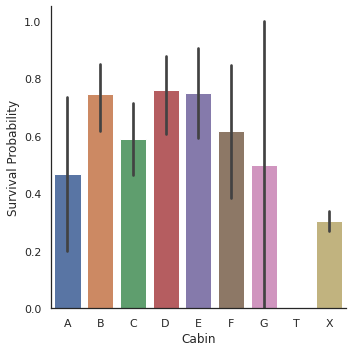

In [ ]:
g=sns.factorplot(y="Survived",x="Cabin", data=dataset,kind="bar",order=['A','B','C','D','E','F','G','T','X'])
g = g.set_ylabels("Survival Probability")

In [ ]:
dataset = pd.get_dummies(dataset, columns = ["Cabin"],prefix="Cabin")

In [ ]:
dataset["Ticket"].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [ ]:
## Treat Ticket by extracting the ticket prefix. When there is no prefix it returns X.
Ticket = []
for i in list(dataset.Ticket):
    if not i.isdigit() :
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0]) #Take prefix
    else:
        Ticket.append("X")
        
dataset["Ticket"] = Ticket
dataset["Ticket"].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [ ]:
dataset = pd.get_dummies(dataset, columns = ["Ticket"], prefix="T")

In [ ]:
# Create categorical values for Pclass
dataset["Pclass"]=dataset["Pclass"].astype("category")
dataset=pd.get_dummies(dataset,columns=["Pclass"], prefix="Pc")

In [ ]:
# Drop useless variables 
dataset.drop(labels = ["PassengerId"], axis = 1, inplace = True)

In [ ]:
dataset.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_X,T_A,T_A4,T_A5,T_AQ3,T_AQ4,T_AS,T_C,T_CA,T_CASOTON,T_FC,T_FCC,T_Fa,T_LINE,T_LP,T_PC,T_PP,T_PPP,T_SC,T_SCA3,T_SCA4,T_SCAH,T_SCOW,T_SCPARIS,T_SCParis,T_SOC,T_SOP,T_SOPP,T_SOTONO2,T_SOTONOQ,T_SP,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0.0,0,22.0,1,0,1.981001,2,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1.0,1,38.0,1,0,4.266662,2,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,1.0,1,26.0,0,0,2.070022,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
3,1.0,1,35.0,1,0,3.972177,2,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
4,0.0,0,35.0,0,0,2.085672,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1


# **Modeling**

**Splitting dataset into x and y**

In [ ]:


y= dataset["Survived"]
x= dataset.drop(labels = ["Survived"],axis = 1)



**Splitting dataset into training set and test set**

In [ ]:
train_length=len(training_set)
x_train=x[:train_length]
x_test=x[train_length:]
y_train=y[:train_length]
y_test=y[train_length:]

In [ ]:
print(x_train)

     Sex   Age  SibSp  Parch      Fare  ...  T_WEP  T_X  Pc_1  Pc_2  Pc_3
0      0  22.0      1      0  1.981001  ...      0    0     0     0     1
1      1  38.0      1      0  4.266662  ...      0    0     1     0     0
2      1  26.0      0      0  2.070022  ...      0    0     0     0     1
3      1  35.0      1      0  3.972177  ...      0    1     1     0     0
4      0  35.0      0      0  2.085672  ...      0    1     0     0     1
..   ...   ...    ...    ...       ...  ...    ...  ...   ...   ...   ...
876    0  27.0      0      0  2.564949  ...      0    1     0     1     0
877    1  19.0      0      0  3.401197  ...      0    1     1     0     0
878    1  13.5      1      2  3.154870  ...      0    0     0     0     1
879    0  26.0      0      0  3.401197  ...      0    1     1     0     0
880    0  32.0      0      0  2.047693  ...      0    1     0     0     1

[881 rows x 66 columns]


In [ ]:
print(y_train)

0      0.0
1      1.0
2      1.0
3      1.0
4      0.0
      ... 
876    0.0
877    1.0
878    0.0
879    1.0
880    0.0
Name: Survived, Length: 881, dtype: float64


In [ ]:
print(x_test)

      Sex   Age  SibSp  Parch      Fare  ...  T_WEP  T_X  Pc_1  Pc_2  Pc_3
881     0  34.5      0      0  2.057860  ...      0    1     0     0     1
882     1  47.0      1      0  1.945910  ...      0    1     0     0     1
883     0  62.0      0      0  2.270836  ...      0    1     0     1     0
884     0  27.0      0      0  2.159003  ...      0    1     0     0     1
885     1  22.0      1      1  2.508582  ...      0    1     0     0     1
...   ...   ...    ...    ...       ...  ...    ...  ...   ...   ...   ...
1294    0  25.0      0      0  2.085672  ...      0    0     0     0     1
1295    1  39.0      0      0  4.690430  ...      0    0     1     0     0
1296    0  38.5      0      0  1.981001  ...      0    0     0     0     1
1297    0  25.0      0      0  2.085672  ...      0    1     0     0     1
1298    0  16.0      1      1  3.107198  ...      0    1     0     0     1

[418 rows x 66 columns]


In [ ]:
print(y_test)

881    NaN
882    NaN
883    NaN
884    NaN
885    NaN
        ..
1294   NaN
1295   NaN
1296   NaN
1297   NaN
1298   NaN
Name: Survived, Length: 418, dtype: float64


# **Training**

**Stratified Cross validation procedure**

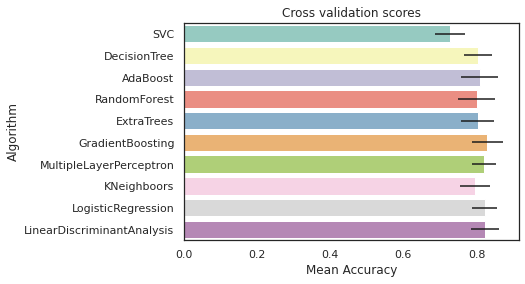

In [ ]:
#Evaluating mean accuracies of different Classifiers
kfold=StratifiedKFold(n_splits=10)
random_state=2
classifiers=[]
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state=random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results=[]
for classifier in classifiers:
  cv_results.append(cross_val_score(classifier, x_train, y=y_train, scoring="accuracy", cv=kfold, n_jobs=4 ))
cv_means=[]
cv_std=[]
for cv_result in cv_results:
  cv_means.append(cv_result.mean())
  cv_std.append(cv_result.std())
cv_res=pd.DataFrame({"CrossValMeans":cv_means, "CrossValerrors":cv_std, "Algorithm":["SVC","DecisionTree","AdaBoost","RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})  
g=sns.barplot("CrossValMeans","Algorithm",data=cv_res, palette="Set3", orient="h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g=g.set_title("Cross validation scores")


### **Hyperperameter tunning for best models**

In [ ]:
#Meta Modelling with AdaBoost, Rf, Extratrees and GradientBoosting
#Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsadaDTC.fit(x_train,y_train)

ada_best = gsadaDTC.best_estimator_


Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:    9.4s
[Parallel(n_jobs=4)]: Done 1113 out of 1120 | elapsed:   20.0s remaining:    0.1s
[Parallel(n_jobs=4)]: Done 1120 out of 1120 | elapsed:   20.1s finished


In [ ]:
gsadaDTC.best_score_

0.82073544433095

In [ ]:
#ExtraTrees
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsExtC.fit(x_train,y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_


Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   12.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   43.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  2.2min finished


0.8308861082737486

In [ ]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(x_train,y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_


Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   13.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   46.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  2.4min finished


0.832035240040858

In [ ]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(x_train,y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_


Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  58 tasks      | elapsed:    8.7s
[Parallel(n_jobs=4)]: Done 208 tasks      | elapsed:   28.0s
[Parallel(n_jobs=4)]: Done 458 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:  1.6min finished


0.8331460674157303

In [ ]:
### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsSVMC.fit(x_train,y_train)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    9.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   47.0s
[Parallel(n_jobs=4)]: Done 280 out of 280 | elapsed:  1.3min finished


0.8331332992849847

### **Plotting Learning Curves**

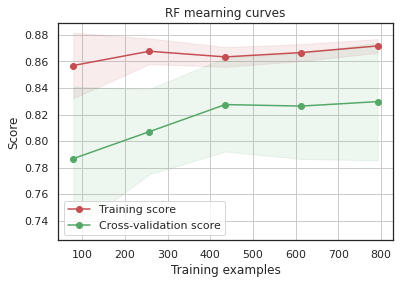

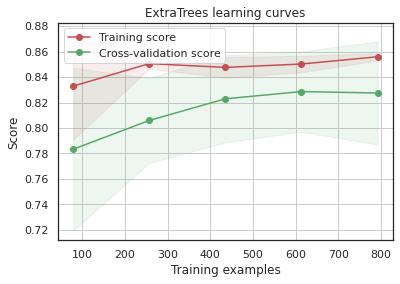

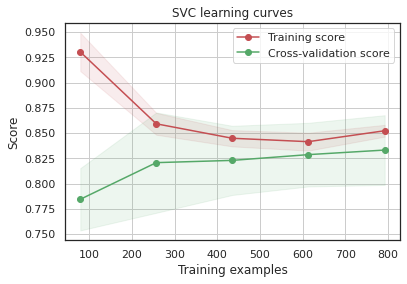

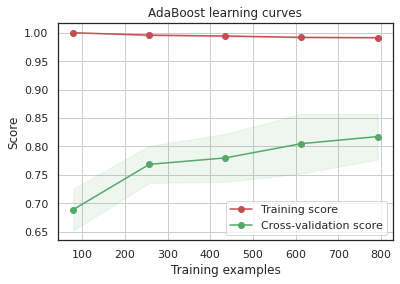

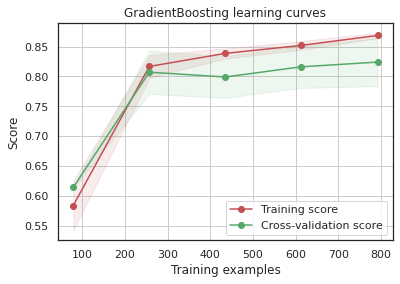

In [ ]:
def plot_learning_curve(estimator, title, x, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, x, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",x_train,y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",x_train,y_train,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",x_train,y_train,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",x_train,y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",x_train,y_train,cv=kfold)


**Feature importance of tree based classifiers**

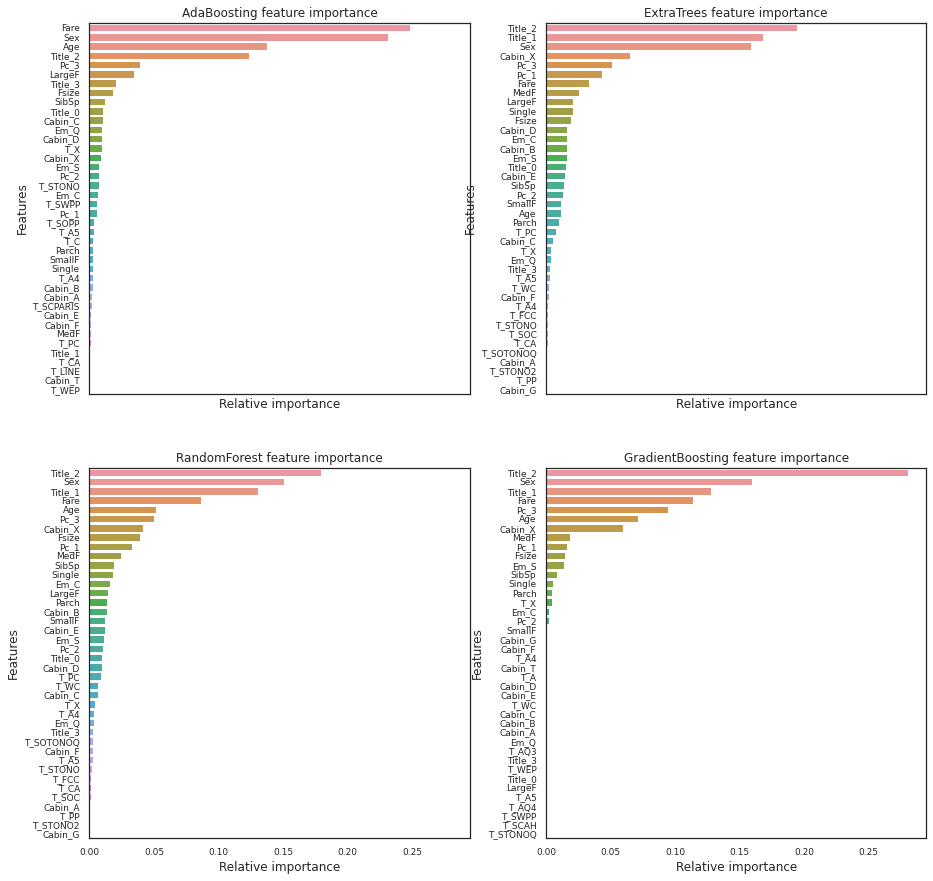

In [ ]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best),("ExtraTrees",ExtC_best),("RandomForest",RFC_best),("GradientBoosting",GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=x_train.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

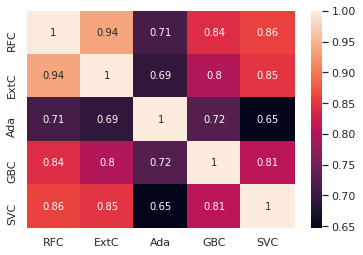

In [ ]:
test_Survived_RFC = pd.Series(RFC_best.predict(x_test), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(x_test), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(x_test), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(x_test), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(x_test), name="GBC")


# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_AdaC,test_Survived_GBC, test_Survived_SVMC],axis=1)


g= sns.heatmap(ensemble_results.corr(),annot=True)

# **Ensemble Modeling**

**Combining models**

In [ ]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),
('svc', SVMC_best), ('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(x_train, y_train)

# **Prediciton**

In [ ]:
test_Survived = pd.Series(votingC.predict(x_test), name="Survived")

results = pd.concat([Idtest,test_Survived],axis=1)

results.to_csv("ensemble_python_voting.csv",index=False)